 # 1. Solving the CartPole Problem

## 1.1 Q-Learning

- conda install -c conda-forge gym

In [2]:
import gym
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

class QLearning():
    def __init__(self, buckets=(2, 2, 6, 6), number_episodes=175, min_lr=0.1, min_epsilon=0.1, discount=1.0, decay=25):
        '''
        Initialize all the necessary attributes and set the environment as 'CartPole-v0'
        '''
        self.buckets = buckets
        self.number_episodes = number_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        self.env = gym.make('CartPole-v0')
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.steps = np.zeros(self.number_episodes)
        
    def discretize_state(self, observations):
        '''
        The observations is a tuple and includes four floats representing the current state of the environment
        The discretized is a tuple and includes four non-negative interger less than the number in the same position in the buckets list
        Returns: the tuple discretized
        '''
        discretized = list()
        for i in range(len(observations)):
            scaling = ((observations[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i]))
            temp_obs = int(round((self.buckets[i] - 1) * scaling))
            temp_obs = min(self.buckets[i] - 1, max(0, temp_obs))
            discretized.append(temp_obs)
        return tuple(discretized)
        
    def choose_action(self, state):
        '''
        Choose action and return 0 or 1 as action
        The state is a tuple and includes four non-negative interger which are within the range of the bucket
        Return 0 or 1 (interger) as output
        '''
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q_table[state])
            
    def get_action(self, state, e):
        '''
        Apply epsilon greedy assuming that the state not discretized
        State: a tuple and includes four floats which are represents the current state of the environment
        e: an interger
        Return the act_vector with the problities for each action
        '''
        observations = self.discretize_state(state)
        act_vector = self.Q_table[observations]
        epsilon = max(self.min_epsilon, min(1., 1. - math.log10((e + 1) / self.decay)))
        act_vector = self.normalize(act_vector, epsilon)
        return act_vector
        
    def normalize(self, act_vector, epsilon):
        '''
        The act_vector is an array and contains the expected value of each action in the current state
        The epsilon is a float and represents the chances that choose an action randomly by epsilon greedy
        Returns new_vector is an array and represents the problities for each action which being chosen at the current state
        '''
        total = sum(act_vector)
        new_vector = (1-epsilon) * act_vector / (total)
        new_vector += epsilon / 2.0
        return new_vector
        
        
    def update_q_table(self, state, action, reward, new_state):
        '''
        Update the Q-table with rules
        '''
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])
        
        
    def train(self):
        '''
        Train the agent, make it through the environment and choose action through the E-greed policy and update its Q table values
        '''
        for e in range(self.number_episodes):
            current_state = self.discretize_state(self.env.reset())
            self.learning_rate = max(self.min_lr, min(1., 1. - math.log10((e + 1) / self.decay)))
            self.epsilon = max(self.min_epsilon, min(1., 1. - math.log10((e + 1) / self.decay)))
            done = False
            
            while not done:
                self.steps[e] += 1
                action = self.choose_action(current_state)
                observations, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(observations)
                self.update_q_table(current_state, action, reward, new_state)
                current_state = new_state

        print('The trainning has been finished!')
    
    
    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
            self.env.render()
            t = t+1
            action = self.choose_action(current_state)
            observations, reward, done, _ = self.env.step(action)
            new_state = self.discretize_state(observations)
            current_state = new_state
            
        return t
    
    
    def plot_episode(self):
        '''
        Draw the number of steps in each episode and print the amount of an episode completes successfully
        '''
        sns.lineplot(range(len(self.steps)), self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.number_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "The episodes have been successfully finished!")

The trainning has been finished!


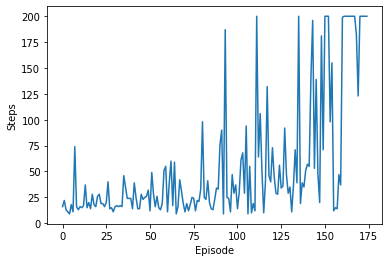

17 The episodes have been successfully finished!


In [3]:
if __name__ == '__main__':
    CartPoleAgent = QLearning()
    CartPoleAgent.train()
    # CartPoleAgent.run()
    CartPoleAgent.plot_episode()

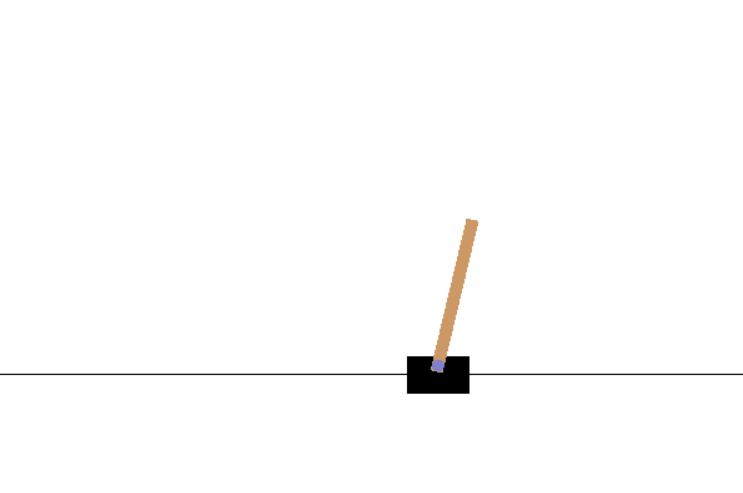

## 1.2 Sarsa Algorithm 

In [13]:
import gym
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

class Sarsa():
    def __init__(self, buckets=(2, 2, 6, 6), num_episodes=500, min_lr=0.1, min_epsilon=0.1, discount=0.98, decay=25):
        '''
        Initialize all the necessary attributes and set the environment as 'CartPole-v0'
        '''
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        self.env = gym.make('CartPole-v0')
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.sarsa_table = np.zeros(self.buckets + (self.env.action_space.n,))
        self.steps = np.zeros(self.num_episodes)
        
        
    def discretize_state(self, obs):
        '''
        The observations is a tuple and includes four floats representing the current state of the environment
        The discretized is a tuple and includes four non-negative interger less than the number in the same position in the buckets list
        Returns: the tuple discretized
        '''
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    
    def choose_action(self, state):
        '''
        Choose action and return 0 or 1 as action
        The state is a tuple and includes four non-negative interger which are within the range of the bucket
        Return 0 or 1 (interger) as output
        '''
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.sarsa_table[state])
    
    
    def update_sarsa(self, state, action, reward, new_state, new_action):
        '''
        Update the sarsa-table with rules
        '''
        self.sarsa_table[state][action] += self.learning_rate * (reward + self.discount * (self.sarsa_table[new_state][new_action]) - self.sarsa_table[state][action])


    def train(self):
        '''
        Train the agent, make it through the environment and choose action through the Sarsa policy and update its Sarsa table values
        '''
        for e in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())

            self.learning_rate = max(self.min_epsilon, min(1., 1. - math.log10((e + 1) / self.decay)))
            self.epsilon = max(self.min_epsilon, min(1., 1. - math.log10((e + 1) / self.decay)))
            done = False
            while not done:
                self.steps[e] += 1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                new_action = self.choose_action(new_state)
                self.update_sarsa(current_state, action, reward, new_state, new_action)
                current_state = new_state

        print('The trainning has been finished!')
        
    
    def run(self):
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t
    
    
    def plot_episode(self):
        '''
        Draw the number of steps in each episode and print the amount of an episode completes successfully
        '''
        sns.lineplot(range(len(self.steps)), self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        print("The episodes have been successfully finished!")

The trainning has been finished!


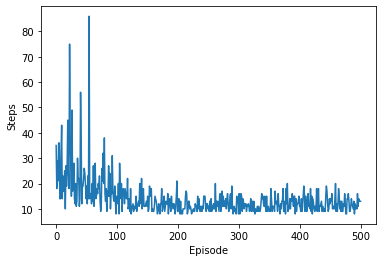

The episodes have been successfully finished!


In [21]:
if __name__ == '__main__':
    CartPoleSarsa = Sarsa()
    CartPoleSarsa.train()
    # CartPoleSarsa.run()
    CartPoleSarsa.plot_episode()

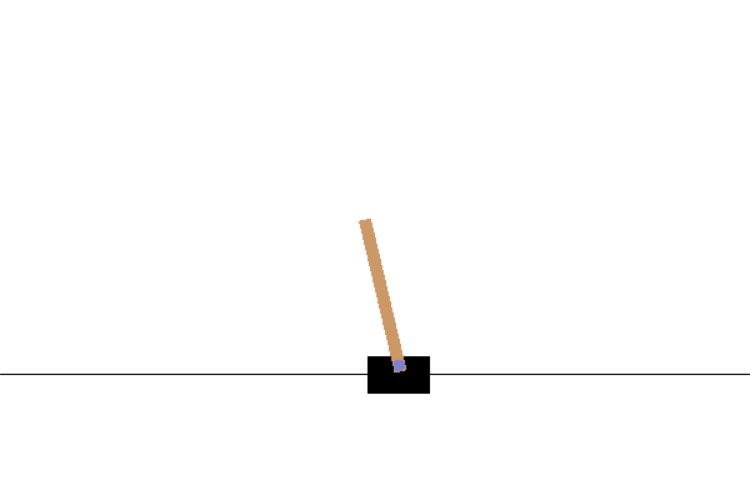